In [188]:
import jax
import jax.numpy as jnp
from flax import linen as nn
import optax

import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

import pickle

In [189]:
# Load MNIST dataset
(raw_train_images, raw_train_labels), (raw_test_images, raw_test_labels) = tfds.load('mnist', split=['train', 'test'], as_supervised=True, batch_size=-1)

In [190]:
# convert to JAX arrays
train_images = jnp.array(raw_train_images)
train_labels = jnp.array(raw_train_labels)
test_images = jnp.array(raw_test_images)
test_labels = jnp.array(raw_test_labels)

In [191]:
def show_digits(images, labels=None, n=30, rows=3, cols=10, figsize=(20, 6)):
    fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=figsize)
    axs = axs.reshape((-1,))
    for i in range(n): 
        axs[i].imshow(images[i], cmap="gray")
        if labels is not None:
            axs[i].set_title(labels[i])
        axs[i].axis("off")

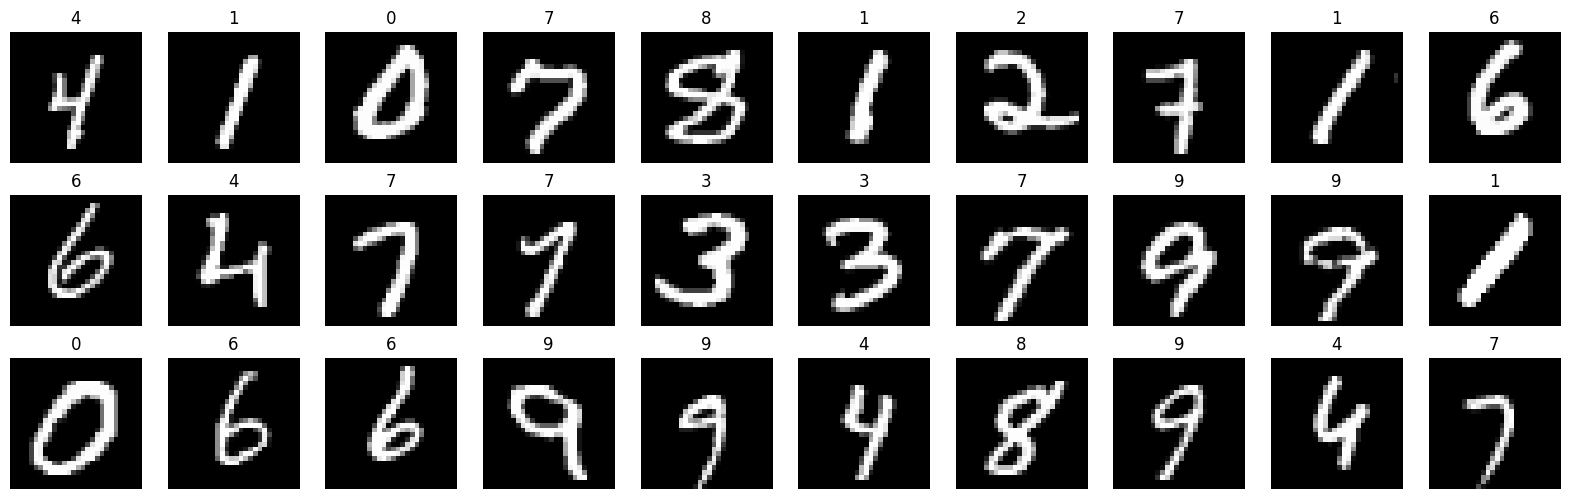

In [192]:
show_digits(train_images[:30], train_labels[:30])

In [193]:
# Explore the dataset
print("Train images: ", train_images.shape[0])
print("Test images: ", test_images.shape[0])
print("Image shape: ", train_images.shape[1:])

print("\nNumber of classes: ", len(jnp.unique(train_labels)))
print("class 0: ", jnp.sum(train_labels == 0))
print("class 1: ", jnp.sum(train_labels == 1))
print("class 2: ", jnp.sum(train_labels == 2))
print("class 3: ", jnp.sum(train_labels == 3))
print("class 4: ", jnp.sum(train_labels == 4))
print("class 5: ", jnp.sum(train_labels == 5))
print("class 6: ", jnp.sum(train_labels == 6))
print("class 7: ", jnp.sum(train_labels == 7))
print("class 8: ", jnp.sum(train_labels == 8))
print("class 9: ", jnp.sum(train_labels == 9))

Train images:  60000
Test images:  10000
Image shape:  (28, 28, 1)

Number of classes:  10
class 0:  5923
class 1:  6742
class 2:  5958
class 3:  6131
class 4:  5842
class 5:  5421
class 6:  5918
class 7:  6265
class 8:  5851
class 9:  5949


In [194]:
# Use only the images of the digit 1, 4 and 8
digit_0 = train_images[train_labels == 0][:5000]
digit_1 = train_images[train_labels == 1][:5000]
digit_2 = train_images[train_labels == 2][:5000]
digit_3 = train_images[train_labels == 3][:5000]
digit_4 = train_images[train_labels == 4][:5000]
digit_5 = train_images[train_labels == 5][:5000]
digit_6 = train_images[train_labels == 6][:5000]
digit_7 = train_images[train_labels == 7][:5000]
digit_8 = train_images[train_labels == 8][:5000]
digit_9 = train_images[train_labels == 9][:5000]

train_images = jnp.concatenate([digit_0, digit_1, digit_2, digit_3, digit_4, digit_5, digit_6, digit_7, digit_8, digit_9], axis=0)
train_labels = jnp.concatenate([jnp.zeros(1000), jnp.ones(1000), 2*jnp.ones(1000), 3*jnp.ones(1000), 4*jnp.ones(1000), 5*jnp.ones(1000), 6*jnp.ones(1000), 7*jnp.ones(1000), 8*jnp.ones(1000), 9*jnp.ones(1000)], axis=0).astype(jnp.int32)

# Normalize the images
train_images = train_images / 255.0

# Scale the images to the range [-1, 1]
train_images = 2 * train_images - 1

print("Train images: ", train_images.shape)
print("Train labels: ", train_labels.shape)

Train images:  (50000, 28, 28, 1)
Train labels:  (10000,)


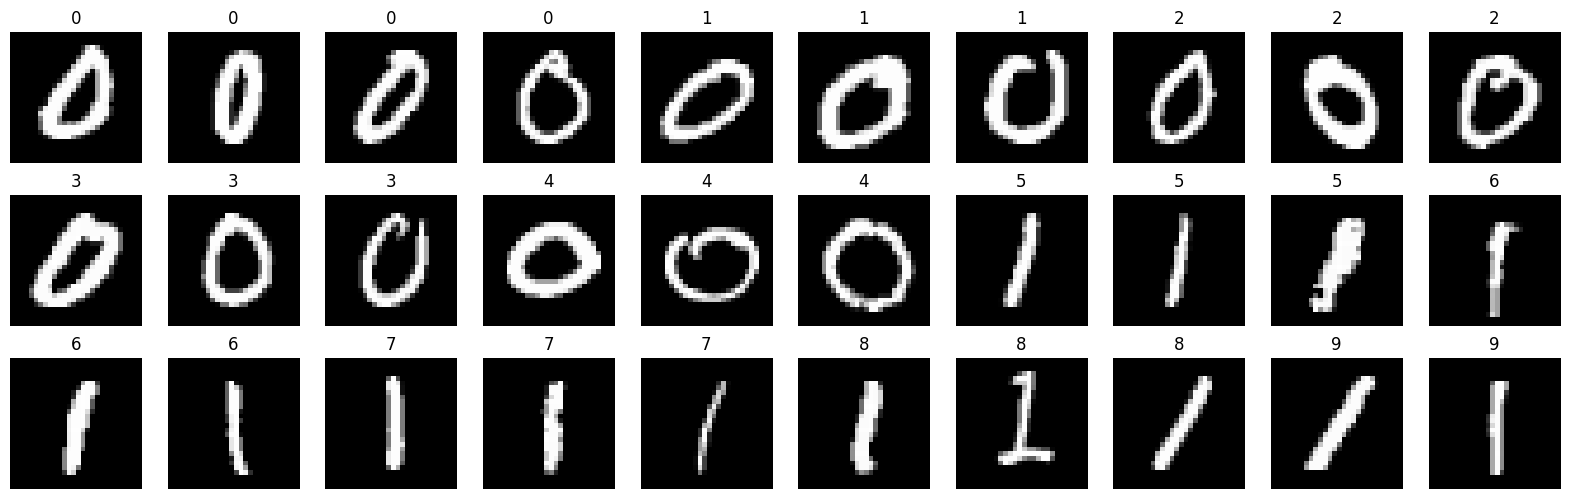

In [195]:
show_digits(train_images[::333][:30], train_labels[::333][:30])

### Generator and Discriminator Networks

The **Generator** creates fake images from random noise, while the **Discriminator** distinguishes between real and fake images.

- **Generator:**
  - Takes a latent vector as input.
  - Uses two hidden layers with ReLU activation.
  - Outputs an image with pixel values scaled between `[-1, 1]` using Tanh.

- **Discriminator:**
  - Takes an image as input.
  - Uses two hidden layers with Leaky ReLU activation.
  - Outputs a single value (logit) indicating the probability of the image being real.

In [196]:
class Generator(nn.Module):
    num_classes: int
    latent_dim: int

    @nn.compact
    def __call__(self, z, labels):
        # Hot encode the labels
        labels = nn.one_hot(labels, self.num_classes)
        x = jnp.concatenate([z, labels], axis=-1)

        # Generator network
        x = nn.Dense(128, kernel_init=nn.initializers.xavier_uniform())(x)
        x = nn.relu(x)
        x = nn.Dense(256, kernel_init=nn.initializers.xavier_uniform())(x)
        x = nn.relu(x)
        x = nn.Dense(28 * 28, kernel_init=nn.initializers.xavier_uniform())(x)
        x = nn.tanh(x)
        
        return x.reshape(-1, 28, 28, 1)
    
class Discriminator(nn.Module):
    num_classes: int
    embedding_dim: int

    @nn.compact
    def __call__(self, x, labels):
        # Embed the labels
        label_embed = nn.Embed(num_embeddings=self.num_classes, features=self.embedding_dim)(labels)

        # Concatenate the images with the label embeddings
        x = x.reshape(-1, 28 * 28) # Flatten the images
        x = jnp.concatenate([x, label_embed], axis=-1)

        # Discriminator network
        x = nn.Dense(256, kernel_init=nn.initializers.xavier_uniform())(x)
        x = nn.leaky_relu(x, negative_slope=0.2)
        x = nn.Dense(128, kernel_init=nn.initializers.xavier_uniform())(x)
        x = nn.leaky_relu(x, negative_slope=0.2)
        x = nn.Dense(1, kernel_init=nn.initializers.xavier_uniform())(x)
        x = nn.sigmoid(x)
        
        return x

qualche commento

In [197]:
# Initialize the Generator and Discriminator
latent_dim = 128
num_classes = 10  # For MNIST, there are 10 classes (digits 0-9)
image_size = 28 * 28  # MNIST image size
embedding_dim = 10
gen_learning_rate = 1e-4
disc_learning_rate = 2e-5

# Create Generator and Discriminator instances
gen = Generator(num_classes=num_classes, latent_dim=latent_dim)
disc = Discriminator(num_classes=num_classes, embedding_dim=embedding_dim)

# Initialize PRNG keys
key = jax.random.PRNGKey(0)
gen_key, disc_key = jax.random.split(key)

# Initialize the generator and discriminator parameters
gen_params = gen.init(gen_key, jnp.ones((1, latent_dim)), jnp.array([0]))
disc_params = disc.init(disc_key, jnp.ones((1, 28, 28, 1)), jnp.array([1]))

# Create optimizers
# lr_schedule = optax.exponential_decay(init_value=1e-4, decay_rate=0.9, decay_steps=5000)
# optimizer = optax.adam(learning_rate=lr_schedule)

gen_optimizer = optax.adam(gen_learning_rate)
disc_optimizer = optax.adam(disc_learning_rate)

# Initialize optimizer states
gen_opt_state = gen_optimizer.init(gen_params)
disc_opt_state = disc_optimizer.init(disc_params)

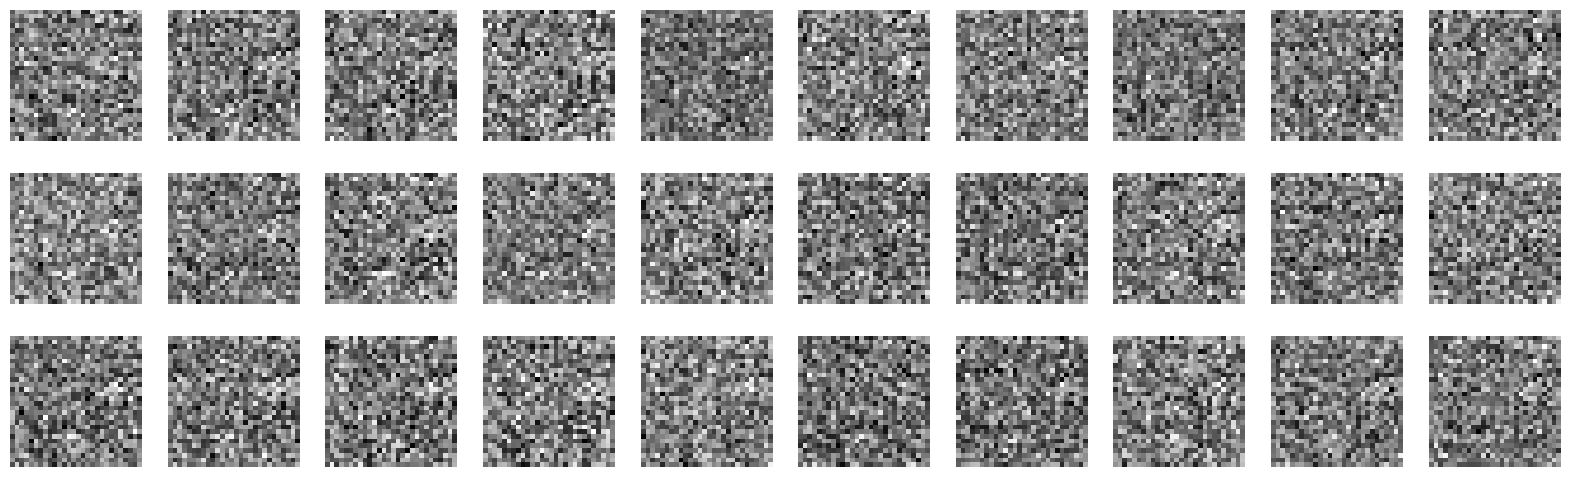

In [198]:
show_digits(gen.apply(gen_params, jax.random.normal(gen_key, (30, latent_dim)), jnp.arange(30)%10), n=30)

In [199]:
# Print generator parameters
print("Generator parameters:")
for param_name, layer in gen_params['params'].items():
    if param_name == "Embed_0":
        print(f"  Shape of {param_name}:\n    Embedding", layer['embedding'].shape)
    else:
        print(f"  Shape of {param_name}:\n    Bias: {layer['bias'].shape}\n    Kernel: {layer['kernel'].shape}")

# Print discriminator parameters
print("\nDiscriminator parameters:")
for param_name, layer in disc_params['params'].items():
    if param_name == "Embed_0":
        print(f"  Shape of {param_name}:\n    Embedding", layer['embedding'].shape)
    else:
        print(f"  Shape of {param_name}:\n    Bias: {layer['bias'].shape}\n    Kernel: {layer['kernel'].shape}")

Generator parameters:
  Shape of Dense_0:
    Bias: (128,)
    Kernel: (138, 128)
  Shape of Dense_1:
    Bias: (256,)
    Kernel: (128, 256)
  Shape of Dense_2:
    Bias: (784,)
    Kernel: (256, 784)

Discriminator parameters:
  Shape of Embed_0:
    Embedding (10, 10)
  Shape of Dense_0:
    Bias: (256,)
    Kernel: (794, 256)
  Shape of Dense_1:
    Bias: (128,)
    Kernel: (256, 128)
  Shape of Dense_2:
    Bias: (1,)
    Kernel: (128, 1)


### GAN Loss Functions

#### Discriminator Loss $ L_D $

The discriminator loss $ L_D $ is a binary cross-entropy loss, defined as:

$$
L_D = - \mathbb{E}_{x \sim p_{\text{data}}} \left[ \log D(x) \right] - \mathbb{E}_{z \sim p_z} \left[ \log \left( 1 - D(G(z)) \right) \right]
$$

Where:
- $ D(x) $ should output 1 for real images.
- $ D(G(z)) $ should output 0 for fake images generated by $ G(z) $.

This loss encourages the discriminator to correctly classify real and fake images.

#### Generator Loss $ L_G $

The generator loss $ L_G $ aims to fool the discriminator into classifying fake images as real. It is typically defined as:

$$
L_G = - \mathbb{E}_{z \sim p_z} \left[ \log D(G(z)) \right]
$$

Where:
- $ D(G(z)) $ represents the discriminator’s probability of classifying a generated image $ G(z) $ as real.

This loss encourages the generator to improve its ability to produce images that the discriminator cannot distinguish from real ones.

In [200]:
@jax.jit
def generator_loss(gen_params, disc_params, z, labels):
    # Generate fake images from two different latent vectors
    fake_images1 = gen.apply(gen_params, z, labels)

    # Get the discriminator's predictions on the first set of fake images
    fake_preds = disc.apply(disc_params, fake_images1, labels)

    return -jnp.mean(jnp.log(jnp.clip(fake_preds, 1e-7, 1.0)))

@jax.jit
def discriminator_loss(disc_params, real_images, fake_images, labels):
    # Get the discriminator's predictions on real and fake images
    real_preds = disc.apply(disc_params, real_images, labels)
    fake_preds = disc.apply(disc_params, fake_images, labels)

    # Calculate the loss
    real_loss = -jnp.mean(jnp.log(jnp.clip(real_preds, 1e-7, 1.0)))
    fake_loss = -jnp.mean(jnp.log(jnp.clip(1.0 - fake_preds, 1e-7, 1.0)))

    return real_loss + fake_loss

Commento

In [201]:
@jax.jit
def train_generator(gen_params, disc_params, gen_opt_state, z, labels):
    # Calculate the generator loss (Depends on both the generator and discriminator parameters)
    gen_loss, gen_grads = jax.value_and_grad(generator_loss)(gen_params, disc_params, z, labels)

    # Update generator
    gen_updates, gen_opt_state = gen_optimizer.update(gen_grads, gen_opt_state)
    gen_params = optax.apply_updates(gen_params, gen_updates)

    return gen_params, gen_opt_state, gen_loss

@jax.jit
def train_discriminator(disc_params, disc_opt_state, real_images, fake_images, labels):
    # Calculate the discriminator loss (Should only depend on the discriminator parameters)
    disc_loss, disc_grads = jax.value_and_grad(discriminator_loss)(disc_params, real_images, fake_images, labels)

    # Update discriminator
    disc_updates, disc_opt_state = disc_optimizer.update(disc_grads, disc_opt_state)
    disc_params = optax.apply_updates(disc_params, disc_updates)

    return disc_params, disc_opt_state, disc_loss


In [202]:
@jax.jit
def train_step(gen_params, disc_params, gen_opt_state, disc_opt_state, real_images, labels, z):
    # Generate fake images
    fake_images = gen.apply(gen_params, z, labels)

    # Calculate the discriminator loss (Should only depend on the discriminator parameters)
    disc_loss, disc_grads = jax.value_and_grad(discriminator_loss)(disc_params, real_images, fake_images, labels)

    # Update discriminator
    disc_updates, disc_opt_state = disc_optimizer.update(disc_grads, disc_opt_state)
    disc_params = optax.apply_updates(disc_params, disc_updates)

    # Calculate the generator loss (Depends on both the generator and discriminator parameters)
    gen_loss, gen_grads = jax.value_and_grad(generator_loss)(gen_params, disc_params, z, labels)

    # Update generator
    gen_updates, gen_opt_state = gen_optimizer.update(gen_grads, gen_opt_state)
    gen_params = optax.apply_updates(gen_params, gen_updates)

    return gen_params, disc_params, gen_opt_state, disc_opt_state, gen_loss, disc_loss

In [203]:
sample_z = jax.random.normal(key, (10, latent_dim))
sample_labels = jnp.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
gen_images = []
losses = []

In [259]:
num_epochs = 10
batch_size = 64
num_batches = train_images.shape[0] // batch_size

for epoch in range(num_epochs):
    # Generate a new random keys
    key, shuffle_key, z_key, noise_key = jax.random.split(key, 4)
    
    # Shuffle the dataset
    indeces = jax.random.permutation(shuffle_key, jnp.arange(train_images.shape[0]))
    train_images = train_images[indeces]
    train_labels = train_labels[indeces]

    # Generate random latent vectors
    zs = jax.random.normal(z_key, (num_batches, batch_size, latent_dim))

    # Iterate over the dataset
    for i in range(num_batches):
        # Get a batch of real images and labels
        real_images = train_images[i:i + batch_size]
        labels = train_labels[i:i + batch_size]

        # Get the corresponding latent vectors
        z = zs[i]

        # # Train discriminator and generator
        # gen_params, disc_params, gen_opt_state, disc_opt_state, gen_loss, disc_loss = train_step(gen_params, disc_params, gen_opt_state, disc_opt_state, real_images, labels, z)

        if epoch % 2 == 0:
            # Train the generator
            gen_params, gen_opt_state, gen_loss = train_generator(gen_params, disc_params, gen_opt_state, z, labels)
        else:
            # Train the discriminator
            fake_images = gen.apply(gen_params, z, labels)
            disc_params, disc_opt_state, disc_loss = train_discriminator(disc_params, disc_opt_state, real_images, fake_images, labels)

    if epoch % 2 == 0:
        # Generate sample images
        gen_images.append(gen.apply(gen_params, sample_z, sample_labels))
    else:
        # Save the generator and discriminator losses for visualization
        losses.append((gen_loss, disc_loss))

    print(f"Epoch {epoch}, " + (f"Generator loss: {gen_loss}" if epoch % 2 == 0 else f"Discriminator loss: {disc_loss}"))

Epoch 0, Generator loss: 0.013153438456356525
Epoch 1, Discriminator loss: 0.012502914294600487
Epoch 2, Generator loss: 0.02698335237801075
Epoch 3, Discriminator loss: 0.006320280954241753
Epoch 4, Generator loss: 0.018439805135130882
Epoch 5, Discriminator loss: 0.04154060408473015
Epoch 6, Generator loss: 0.02692834660410881
Epoch 7, Discriminator loss: 0.007198202423751354
Epoch 8, Generator loss: 0.014710932038724422
Epoch 9, Discriminator loss: 0.018200460821390152


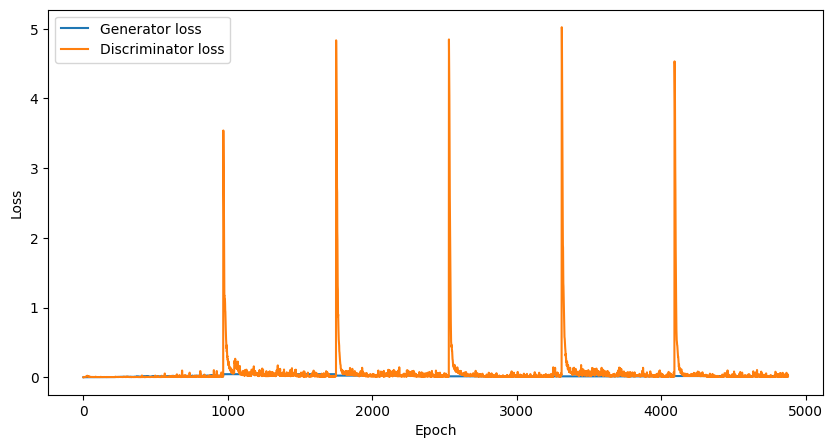

In [260]:
# Plot the losses
gen_losses, disc_losses = zip(*losses)
plt.figure(figsize=(10, 5))
plt.plot(gen_losses, label="Generator loss")
plt.plot(disc_losses, label="Discriminator loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [265]:
# Generate fake images
key = jax.random.PRNGKey(0)
z = jax.random.normal(key, (1000, latent_dim))
labels = jnp.tile(jnp.arange(10), 100)
fake_images = gen.apply(gen_params, z, labels)

digits = [train_images[train_labels == i][:100] for i in range(10)]
real_images = jnp.array([digits[i][j] for i in range(10) for j in range(100)])

# Diversity score
def diversity_score(images):
    images = images.reshape(images.shape[0], -1)
    images = images / jnp.linalg.norm(images, axis=1, keepdims=True)
    similarity = jnp.dot(images, images.T)
    return jnp.mean(similarity) - 1.0

# Quality score
def quality_score(real_images, fake_images):
    real_images = real_images.reshape(real_images.shape[0], -1)
    fake_images = fake_images.reshape(fake_images.shape[0], -1)

    real_images = real_images / jnp.linalg.norm(real_images, axis=1, keepdims=True)
    fake_images = fake_images / jnp.linalg.norm(fake_images, axis=1, keepdims=True)

    similarity = jnp.dot(fake_images, real_images.T)
    return jnp.mean(jnp.max(similarity, axis=1))

print("Real diversity score: ", diversity_score(real_images))
print("Fake diversity score: ", diversity_score(fake_images))
print("Quality score: ", quality_score(real_images, fake_images))

Real diversity score:  -0.29088664
Fake diversity score:  -0.20318556
Quality score:  0.9006513


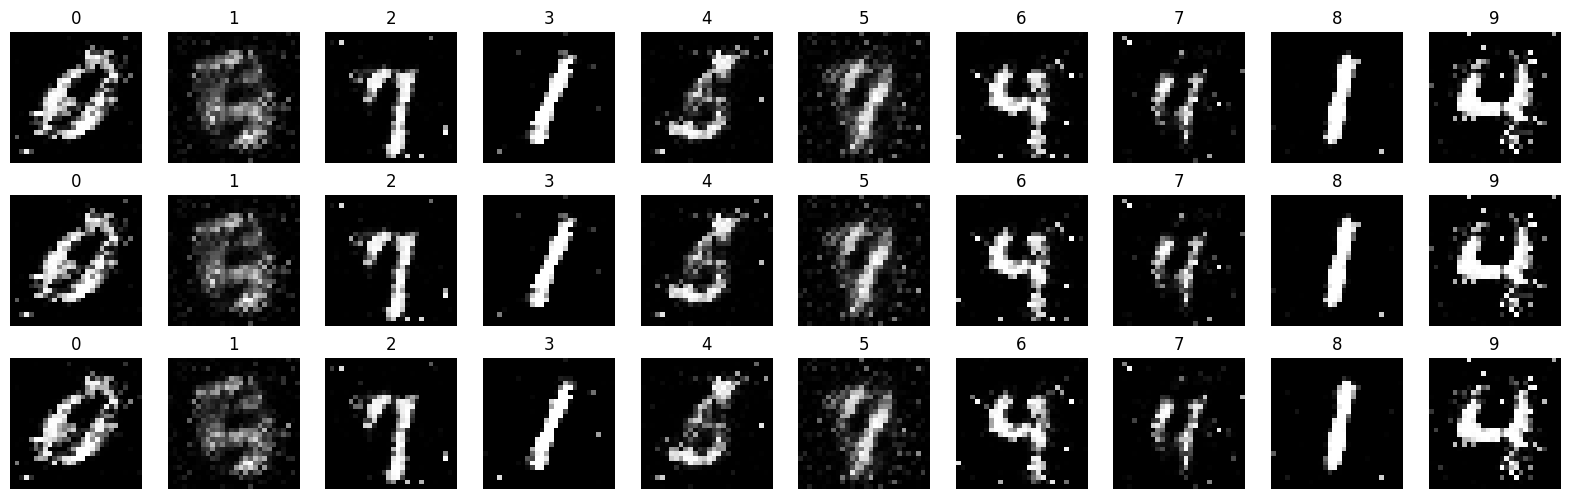

In [246]:
show_digits(jnp.concatenate(gen_images[-3:]), jnp.concatenate([jnp.arange(10)] * 3), n=30, rows=3, cols=10)

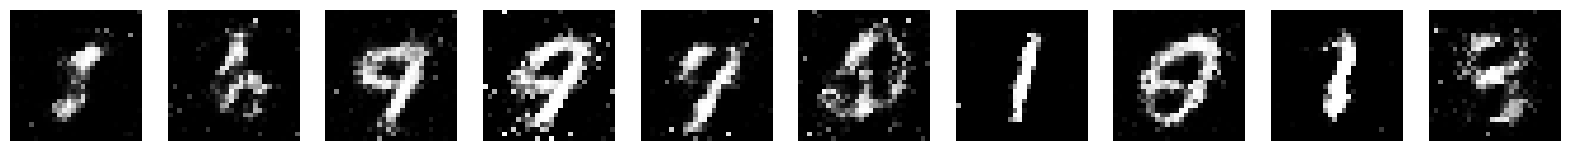

In [264]:
key, subkey = jax.random.split(key)
z = jax.random.normal(subkey, (10, latent_dim))
show_digits(gen.apply(gen_params, z, jnp.arange(10)), n=10, rows=1)

In [266]:
# Save the generator parameters
with open("gen_params.pkl", "wb") as f:
    pickle.dump(gen_params, f)

# Save the discriminator parameters
with open("disc_params.pkl", "wb") as f:
    pickle.dump(disc_params, f)

# Save the generator optimizer state
with open("gen_opt_state.pkl", "wb") as f:
    pickle.dump(gen_opt_state, f)

# Save the discriminator optimizer state
with open("disc_opt_state.pkl", "wb") as f:
    pickle.dump(disc_opt_state, f)

# Save the generator losses and discriminator losses
with open("losses.pkl", "wb") as f:
    pickle.dump(losses, f)


In [23]:
if False:
    # Load the generator parameters
    with open("gen_params.pkl", "rb") as f:
        gen_params = pickle.load(f)

    # Load the discriminator parameters
    with open("disc_params.pkl", "rb") as f:
        disc_params = pickle.load(f)

    # Load the generator optimizer state
    with open("gen_opt_state.pkl", "rb") as f:
        gen_opt_state = pickle.load(f)

    # Load the discriminator optimizer state
    with open("disc_opt_state.pkl", "rb") as f:
        disc_opt_state = pickle.load(f)